# Attention 

Attention is a mechanism that allows the model to focus on specific parts of the input data while performing a task. It’s like how you pay attention to the most important parts of an image or sentence depending on what you're trying to do.

Before attention mechanisms, neural machine translation (NMT) models relied on encoder-decoder architectures with recurrent neural networks (RNNs). These traditional approaches suffered from significant limitations. The entire input sequence had to be compressed into a fixed-length context vector, making it challenging to handle long sequences and maintain performance as sequence length increased.

A pivotal moment came in 2014 with the groundbreaking paper "Neural Machine Translation by Jointly Learning to Align and Translate" by Bahdanau, Cho, and Bengio. This work introduced the fundamental attention mechanism that would reshape sequential data processing.


Attention mechanisms allow neural networks to dynamically focus on different parts of input data during processing. Unlike traditional approaches that compress entire input sequences into a fixed representation, attention enables selective, context-aware information extraction.



#### Step 1: Computing Attention Scores

The first critical step is generating attention scores, which measure the relevance of different input elements:

$$ e_{ij} = \text{score}(h_i, s_{j-1}) $$

- $h_i$ represents the encoder hidden state at a specific input timestep
- $s_{j-1}$ is the decoder's previous hidden state
- The score function determines how important each input element is for the current output

#### Scoring Function Approaches

1. Dot Product Scoring
$$ \text{score}(h_i, s_{j-1}) = h_i^T s_{j-1} $$
A simple method that computes direct similarity between hidden states.

2. Additive (Bahdanau) Scoring
$$ \text{score}(h_i, s_{j-1}) = v^T \tanh(W_1 h_i + W_2 s_{j-1}) $$
A more complex approach allowing non-linear combinations of input states.

#### Step 2: Normalizing Attention Weights

Scores are transformed into normalized probabilities using the softmax function:

$$ \alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{m} \exp(e_{ik})} $$

- Converts raw scores into a probability distribution
- Ensures all weights sum to 1
- Highlights the most relevant input elements

#### Step 3: Creating the Context Vector

The final step generates a context vector by weighted combination of input states:

$$ c_j = \sum_{i=1}^m \alpha_{ij} h_i $$

- Each input state is weighted by its computed attention score
- Produces a dynamic, focused representation for the current output step

#### Self-Attention 

 2017 paper "Attention Is All You Need" by Vaswani et al. This work introduced self-attention, completely replacing recurrent and convolutional layers:

Self-Attention Formula:
$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

Multi-Head Attention extended this concept, allowing simultaneous attention to different representation subspaces:
$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O $$


> Process entire sequences in parallel, Allow direct interaction between all sequence elements and Efficiently capture long-range dependencies


*For deeper insights, the recommended reading is [Attention? Attention!](https://lilianweng.github.io/posts/2018-06-24-attention/)*



# Coding Self-Attention Mechanisms 

### The Problem with Modeling Long Sequences 

Let's go through some pre-Large Language Model (LLM) architectures which do not include attention mechanisms. Suppose we wanted to build a language translation model with an encoder-decoder structure, which is very common in deep neural networks. 

The encoder reads the entire text and understands it, while the decoder produces the translated text. Before the transformer era, there were [RNN](03-sequence-modeling/01-rnn/rnn.ipynb) based encoder and decoder architectures. These architectures performed well on small translation tasks but suffered from long contextual dependencies. Whenever the length of sentences increased, they would lose context. As a result, they could translate text into gibberish language.

**WHY?** Because they were unable to access the hidden state of the previous cell and could only generate text based on the current state. Long Short-Term Memory (LSTM) networks handled this to some extent with a horizontal context line that carries context from one block to the next.

The working of RNNs can be defined as follows: they take the complete input into a hidden state, and the decoder takes this hidden state to produce translated text. (The hidden state is like an understanding of text in numerical form, similar to an embedding.)

### Capturing Data Dependencies with Attention Mechanisms

RNNs needed to remember the entire sentence in a single go (in the hidden state). To overcome this limitation, researchers developed the Bahdanau attention mechanism for RNNs, which modifies the encoder-decoder RNN. This modification allows the decoder to selectively access different parts of the input sequence at each decoding step. As a result, it gains context from both previous and past texts.

### Attending to Different Parts of the Input with Self-Attention

The "self" in self-attention refers to relating a single input sequence to all other parts of the sentence to get the overall input context. This differs from traditional attention mechanisms, which focus on relationships between elements of two different sequences, such as in sequence-to-sequence models where attention might be between an input and an output sequence.

> **A Simple Self-Attention Mechanism without Trainable Weights**

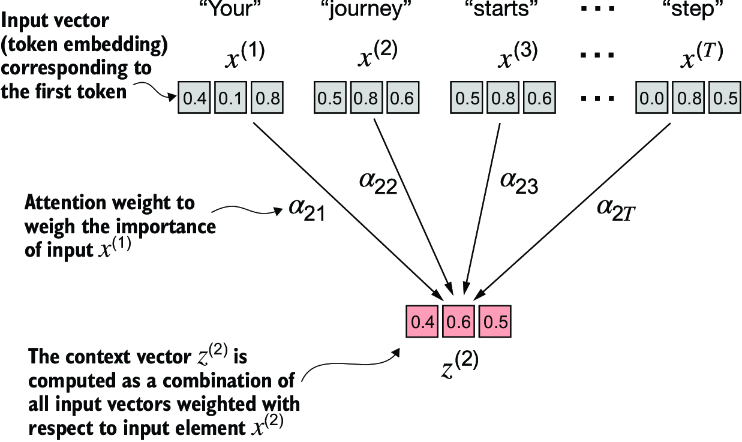

Consider the sentence: "Your journey starts with one step." We divide it into tokens like x1, x2, x3, and so on. Each vector is a three-dimensional embedding. Let's consider the second embedding vector, x2. When we apply self-attention, it becomes z2, which combines information from all other vectors like x1, x3, and x4.

In [23]:
import torch 
from torch import nn
import matplotlib.pyplot as plt 
import numpy as np 

In [24]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [25]:
torch.empty(inputs.shape[0]) # why we use the input.shape[0] cause we wanted the same size of [with 0]


tensor([0., 0., 0., 0., 0., 0.])

In [26]:
query = inputs[1] # x2 
attention_score_x2 = torch.empty(inputs.shape[0]) # creating an empty array 

for i,n in enumerate(inputs):
    
     # x2 will get mul to eveery other tokens 
     # n willl go through all the val in inputs and it will get mul to query that is x2 
     # for example each element in [0.43, 0.15, 0.89] will get mul to each element in elementwise [0.55, 0.87, 0.66]
     # this will genrate new array then we take the sum of array this will gen our first elment in "attention_score_x2" 
    attention_score_x2[i] = torch.dot(n, query)
                                
    
print(attention_score_x2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


#### UNDERSTANDING DOT PRODUCTS

A dot product is essentially a concise way of multiplying two vectors element-wise and then summing the products

> the dot product is a measure of similarity because it quantifies how closely two vectors are aligned: a higher dot product indicates a greater degree of alignment or similarity between the vectors.

In [27]:
res = 0 

for i in range(len(inputs[0])):
    
    res += inputs[0][i] * query[i]
    
print(res)
print(torch.dot(inputs[0],query))

tensor(0.9544)
tensor(0.9544)


In next step we gonna normalise each of the attention score so that the sum all these become ONE but WHY -> if we want stable trianing of LLM then the data should be properly distribuited so it become easy to backprop. 

> We Generally use softmax for this but here we are doing manually just to understanad it.
> Why softmax cause it is better at managing extreme values and offers more favorable gradient properties during training.

In [28]:
attention_score_x2_tmp = attention_score_x2 / attention_score_x2.sum()

print(attention_score_x2_tmp) 
print(attention_score_x2_tmp.sum())

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
tensor(1.0000)


In [29]:
def softmax_tmp(x):
    
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attention_score_x2_softmax = softmax_tmp(attention_score_x2)

print(attention_score_x2_softmax)
print(attention_score_x2_softmax.sum())

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
tensor(1.)


> In addition, the softmax function ensures that the attention weights are always positive. This makes the output interpretable as probabilities or relative importance, where higher weights indicate greater importance.

In [30]:
attn_score_softmax = torch.softmax(attention_score_x2,dim=0)
print(attn_score_softmax)
print(attn_score_softmax.sum())

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
tensor(1.)


> step in calculating attention for llm 

1. the input for ex -> x2 will get multiply to each other inputs and itself also 
2. the attenstion weight will get normlalized(0-1)
3. to cal context vecotr z_2-> we will take -> weighted sum all over inputs 


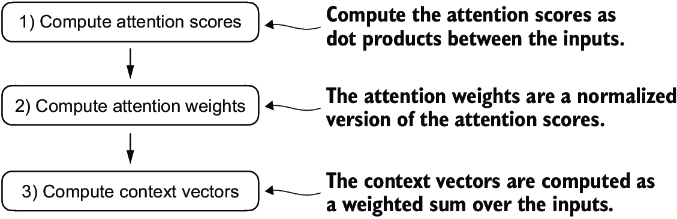

In [38]:
# to cal z_2

query = inputs[1]
# the context vector will the same shape as query 
context_vec_2 = torch.zeros(query.shape)

for i , x_i in enumerate(inputs):
    
  context_vec_2 += attn_score_softmax[i] * x_i 
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


#### 3.3.2 Computing attention weights for all input tokens

Now let’s extend this computation to calculate attention weights and context vectors for all inputs.(still we have only done with x2 and we have done with other x_1,3 and 4)

> attention weights matrix for all six inputs 

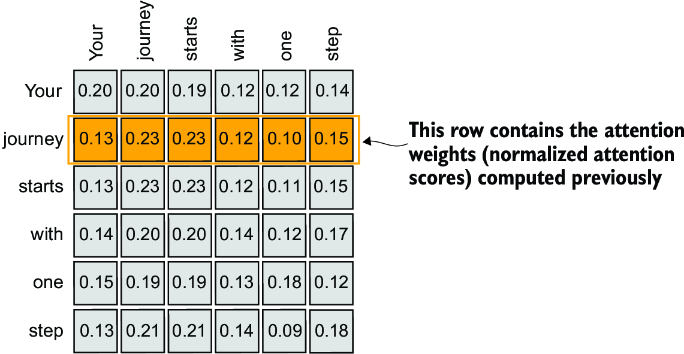


In [39]:
attn_matrix = torch.zeros(6,6)

for i, x_i in enumerate(inputs):
    for j , x_j in enumerate(inputs):
        attn_matrix[i,j] = torch.dot(x_i,x_j)
print(attn_matrix)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


>When computing the preceding attention score tensor, we used `for loops` in Python. However, for loops are generally slow, and we can achieve the same results using matrix multiplication:

In [40]:
attn_matrix_2 = inputs @ inputs.T
attn_matrix_2

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

In [44]:
atten_weights_matrix = torch.softmax(attn_matrix_2,dim=1) # normalising 
# dim = -1 cuase it is first from back 
atten_weights_matrix

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [49]:
sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
atten_weights_matrix.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

>we use these attention weights to compute all context vectors via matrix multiplication:

In [51]:
context_vector_fin = atten_weights_matrix @ inputs
context_vector_fin

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

#### 3.4 Implementing self-attention with trainable weights

We will be adding the weight matrices to the our QKV. This will be updated during the training.

> But WHY we need to weights matrices in first place if current self-attetion is good in understanding
> cause -> These trainable weight matrices are crucial so that the model (specifically, the attention module inside the model) can learn to produce `“good” context vectors.`  


#### 3.4.1 Computing the attention weights step by step

We will implement the self-attention mechanism step by step by introducing the three trainable weight matrices Wq, Wk, and Wv. These three matrices are used to project the embedded input tokens, x(i), into query, key, and value vectors, respectively.

> first step -> we will compute the trainable vectors W_q, W_k and W_v for input element x.
>
> Second step -> we will take our 

In [61]:
x_2 = inputs[1]
d_in = inputs.shape[1] # input embedding 
d_out = 2 # why output embedding size is 2 ? # for better computation 


In [60]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in,d_out), requires_grad = False)
W_key = torch.nn.Parameter(torch.rand(d_in,d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in,d_out), requires_grad=False)

>  we compute the query, key, and value vectors:

In [62]:
query_2 = x_2 @ W_query 
key_2 = x_2 @ W_key 
value = x_2 @ W_value 
print(query_2)

tensor([0.4306, 1.4551])


#### WEIGHT PARAMETERS VS. ATTENTION WEIGHTS


the weight params and attention weights are diffrent. weights param is for learning.(whenever we trained the model), while attention weights are dynamic, context-specific values.
>We can obtain all keys and values via matrix multiplication:

In [63]:
keys = inputs @ W_key 
values = inputs @ W_value
print(keys.shape)
print(values.shape)

torch.Size([6, 2])
torch.Size([6, 2])


>The second step is to compute the attention scores.

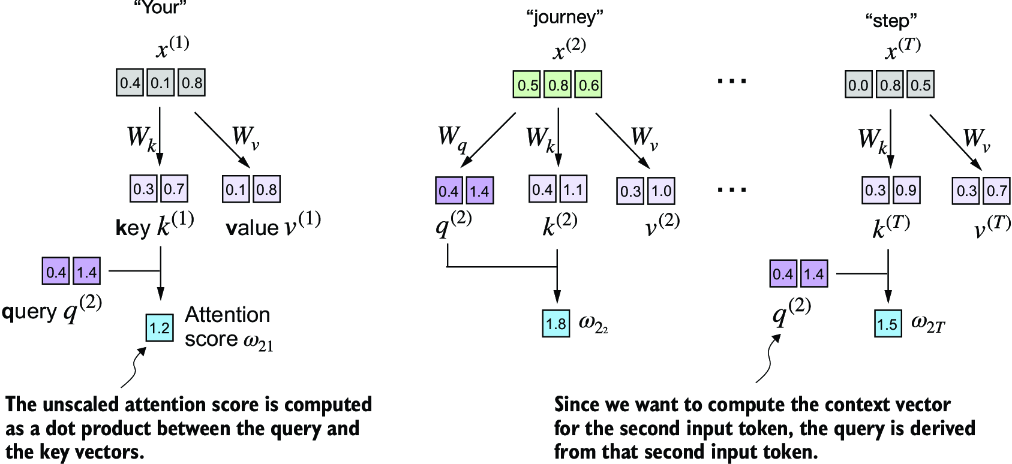

> computing the attention score for the w_22 

In [64]:
keys_2 = keys[1]

attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


> we do same thing but with beter computation 

In [66]:
attn_score_2 = query_2 @ keys.T
print(attn_score_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [70]:
#  attention scores to the attention weights


d_k = keys.shape[1]

attn_weights_2 = torch.softmax(attn_score_2 / d_k ** 0.5, dim = -1)
print(attn_weights_2)


tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


> how ? 

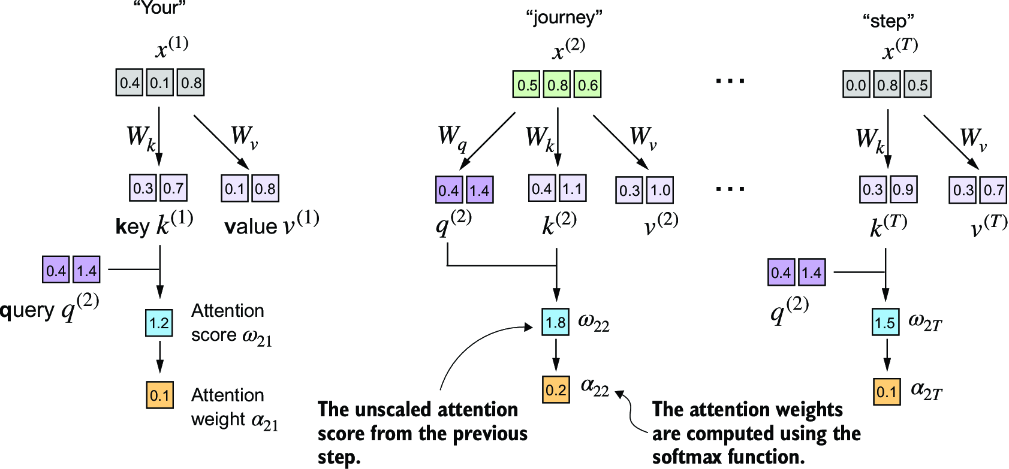

#### THE RATIONALE BEHIND SCALED-DOT PRODUCT ATTENTION

The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. For instance, when scaling up the embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them. As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. These small gradients can drastically slow down learning or cause training to stagnate.

The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.

>  final step is to compute the context vectors.

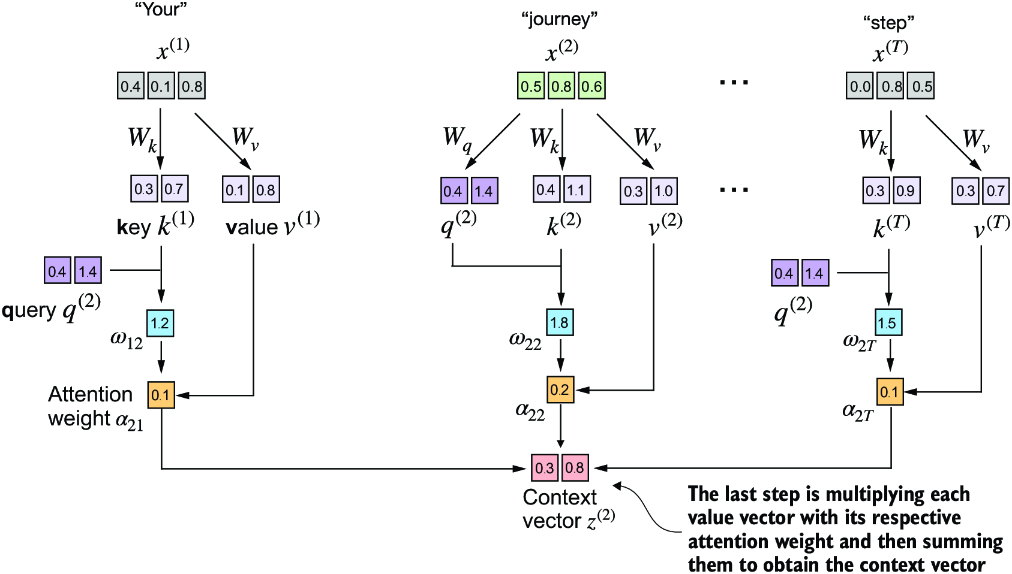

In [71]:
context_vector = attn_weights_2 @ values 
print(context_vector)

tensor([0.3061, 0.8210])


#### WHY QUERY, KEY, AND VALUE?

The terms “key,” “query,” and “value” in the context of attention mechanisms are borrowed from the domain of information retrieval and databases, where similar concepts are used to store, search, and retrieve information.

A query is analogous to a search query in a database. It represents the current item (e.g., a word or token in a sentence) the model focuses on or tries to understand. The query is used to probe the other parts of the input sequence to determine how much attention to pay to them.

The key is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key. These keys are used to match the query.

The value in this context is similar to the value in a key-value pair in a database. It represents the actual content or representation of the input items. Once the model determines which keys (and thus which parts of the input) are most relevant to the query (the current focus item), it retrieves the corresponding values.

#### 3.4.2 Implementing a compact self-attention Python class